## Seq2seq models and attention

This time we'll solve a problem of transribing hebrew words in english, also known as g2p (grapheme2phoneme)

 * word (sequence of letters in source language) -> translation (sequence of letters in target language)


### About the task

One notable property of Hebrew is that it's consonant language. That is, there are no wovels in the written language. One could represent wovels with diacritics above consonants, but you don't expect people to do that in everyay life.

Therefore, some hebrew characters will correspond to several english letters and others - to none, so we should use encoder-decoder architecture to figure that out.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts
  
We chose simplified __Hebrew->English__ machine translation for words and short phrases (character-level), as it is relatively quick to train even without a gpu cluster.

In [1]:
EASY_MODE = True        # If True, only translates phrases shorter than 20 characters (way easier).
                         # Useful for initial coding.
                         # If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                # way we translate. Either "he-to-en" or "en-to-he"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  # maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          # how often to evaluate validation score

### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.

We have implemented this thing for you so that you can focus on more interesting parts.


__Attention python2 users!__ You may want to cast everything to unicode later during homework phase, just make sure you do it _everywhere_.

In [2]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list)  # our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:
        
        en,he = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        word, trans = (he,en) if MODE=='he-to-en' else (en,he)
        
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>20:
                continue
        
        word_to_translation[word].append(trans)
    
print ("size = ",len(word_to_translation))

size =  130113


In [3]:
# get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array([ts for all_ts in word_to_translation.values() for ts in all_ts])


### split the dataset

We hold out 10% of all words to be used for validation.


In [4]:
from sklearn.model_selection import train_test_split
train_words, test_words = train_test_split(all_words,test_size=0.1, random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [5]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [6]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0  43 182 124  48  19 152 116   1   1   1   1   1   1]
 [  0  43 141  26  19 152 116 184 119 154  43  45  19   1]
 [  0  43 154 105  47 141   1   1   1   1   1   1   1   1]
 [  0  43 154 105  33 148   1   1   1   1   1   1   1   1]
 [  0  43  48  19 154  45   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


Draw word/translation length distributions to estimate the scope of the task.

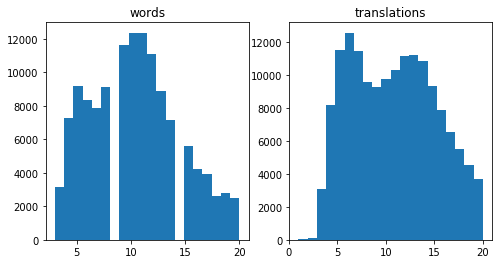

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len, all_words)), bins=20)

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len,all_translations)), bins=20);


### Step 2: deploy encoder-decoder (2 points)

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model.symbolic_translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of hebrew words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
* __`model.symbolic_score(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of hebrew words and their english translations. Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
* __`model.weights`__ - weights from all model layers [a list of variables]

That's all! It's as hard as it gets. With those two methods alone you can implement all kinds of prediction and training.

In [8]:
import tensorflow as tf
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
from basic_model import BasicTranslationModel
model = BasicTranslationModel('model', inp_voc, out_voc,
                              emb_size=32, hid_size=64)

# PLEASE DON'T CHANGE THESE VALUES: emb_size=32, hid_size=64

s.run(tf.global_variables_initializer())

Using TensorFlow backend.


In [10]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])
out = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])

# translate inp (with untrained model)
sampled_out, logp = model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n", out, logp)
print("\nSample translations:\n", s.run(sampled_out))


Symbolic_translate output:
 Tensor("PlaceholderWithDefault_1:0", shape=(?, ?), dtype=int32) Tensor("Reshape_1:0", shape=(?, ?, 283), dtype=float32)

Sample translations:
 [[  0 102 221 172  47 125 232 171  15 260 221]
 [  0 186 158 121 159 148  57 171 232 203 273]
 [  0 231 272 205 132 135  12 152 195  35 222]]


In [11]:
# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp, out)
print("\nSymbolic_score output:\n",logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:,:2,:5])


Symbolic_score output:
 Tensor("Reshape_3:0", shape=(?, ?, 283), dtype=float32)

Log-probabilities (clipped):
 [[[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.64089155  -5.60218191  -5.64623117  -5.64827251  -5.63067198]]

 [[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.68143559  -5.66083765  -5.66380501  -5.67066336  -5.62854147]]

 [[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.63585186  -5.67063379  -5.63933659  -5.63200474  -5.62641382]]]


In [12]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None,None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)
    
def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence: lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)

In [13]:
print("Sample inputs:",all_words[:3])
print("Dummy translations:",translate(all_words[:3]))

assert isinstance(greedy_translations,tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

Sample inputs: ['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו']
Dummy translations: ['', 'לףỏぼטшו≤,п子կḳуuη一àē″ộ&נúлτnì', '⋯rgعťṇ榎(♭v?4野熊ế`uðďש一=ẓı6vп(']
Tests passed!


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [14]:
import editdistance  # !pip install editdistance


def get_distance(word, trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references) != 0, "wrong/unknown word"
    return min(editdistance.eval(trans, ref) for ref in references)


def score(words, bsize=100):
    """
    A function that computes levenshtein distance for bsize random samples
    """
    assert isinstance(words, np.ndarray)
    
    batch_words = np.random.choice(words, size=bsize, replace=False)
    batch_trans = translate(batch_words)
    
    distances = list(map(get_distance, batch_words, batch_trans))
    
    return np.array(distances, dtype='float32')

In [15]:
# should be around 5-50 and decrease rapidly after training :)
[score(test_words, 10).mean() for _ in range(5)]

[35.0, 24.1, 35.799999, 32.0, 35.299999]

## Step 3: Training (2 points)

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [16]:
# import utility functions
from basic_model import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis

class supervised_training:

    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32', [None, None])
    reference_answers = tf.placeholder('int32', [None, None])
    
    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model.symbolic_score(input_sequence, reference_answers)
    
    # compute mean crossentropy
    crossentropy = -select_values_over_last_axis(logprobs_seq, reference_answers)
    
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    
    loss = tf.reduce_sum(crossentropy * mask) / tf.reduce_sum(mask)
    
    # Build weights optimizer. Use model.weights to get all trainable params.
    train_step = tf.train.AdamOptimizer().minimize(loss, var_list=model.weights)
    
    
# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

Actually run training on minibatches

In [17]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x, batch_y = sample_batch(train_words, word_to_translations, 10)
    """
    #choose words
    batch_words = np.random.choice(words, size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get, batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))
    
    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)

In [18]:
bx,by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
[[  0  47 141  47 184 148  48 148 123   1]
 [  0 124  86 154  45  19 148   1   1   1]
 [  0  33 182  47  19  19  26 148   1   1]]
Target:
[[  0 245  79 205 193 245 276  64  79 137 160  64  84 182   1]
 [  0 168  79 202 202  48  84  24 193  79   1   1   1   1   1]
 [  0 186  84 182 245 193  84 253  79   1   1   1   1   1   1]]


In [19]:
from IPython.display import clear_output
from tqdm import tqdm, trange

Some functions to launch training easier

In [20]:
def evaluate(words, supervised_training, bsize=100):
    batch_words = np.random.choice(words, size=bsize, replace=False)
    lines_ix = inp_voc.to_matrix(batch_words)

    # Compute translations in form of indices
    trans_ix = s.run(supervised_training.greedy_translations,
                     {supervised_training.input_sequence: lines_ix})

    # Convert translations back into strings
    batch_trans = out_voc.to_lines(trans_ix)
    
    distances = list(map(get_distance, batch_words, batch_trans))
    
    return np.array(distances, dtype='float32')

In [50]:
def train(model, num_steps=25000):
    class supervised_training:
        # variable for inputs and correct answers
        input_sequence = tf.placeholder('int32', [None, None])
        reference_answers = tf.placeholder('int32', [None, None])
        
        greedy_translations, _ = model.symbolic_translate(input_sequence, greedy=True)
        
        # Compute log-probabilities of all possible tokens at each step. Use model interface.
        logprobs_seq = model.symbolic_score(input_sequence, reference_answers)

        # compute mean crossentropy
        crossentropy = - select_values_over_last_axis(logprobs_seq, reference_answers)

        mask = infer_mask(reference_answers, out_voc.eos_ix)

        loss = tf.reduce_sum(crossentropy * mask) / tf.reduce_sum(mask)

        # Build weights optimizer. Use model.weights to get all trainable params.
        train_step = tf.train.AdamOptimizer(1e-3).minimize(loss, var_list=model.weights)
    
    def translate(lines):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix = inp_voc.to_matrix(lines)

        # Compute translations in form of indices
        trans_ix = s.run(supervised_training.greedy_translations,
                         {supervised_training.input_sequence: lines_ix})

        # Convert translations back into strings
        return out_voc.to_lines(trans_ix)

    initialize_uninitialized(s)
    loss_history = []
    editdist_history = []

    try:
        for i in trange(num_steps):
            bx, by = sample_batch(train_words, word_to_translation, 32)

            feed_dict = {
                supervised_training.input_sequence: bx,
                supervised_training.reference_answers: by
            }

            loss,_ = s.run([supervised_training.loss, supervised_training.train_step], feed_dict)
            loss_history.append(loss)

            if (i + 1) % REPORT_FREQ == 0:
                clear_output(True)
                current_scores = evaluate(test_words, supervised_training)
                editdist_history.append(current_scores.mean())
                plt.figure(figsize=(12, 4))
                plt.subplot(131)
                plt.title('train loss / traning time')
                plt.plot(loss_history)
                plt.grid()
                plt.subplot(132)
                plt.title('val score distribution')
                plt.hist(current_scores, bins=20)
                plt.subplot(133)
                plt.title('val score / traning time')
                plt.plot(editdist_history)
                plt.grid()
                plt.ylim((min(min(editdist_history), 10), 11 if EASY_MODE else 20))
                plt.show()
                print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))
                for word in train_words[:10]:
                    print("%s -> %s"%(word, translate([word])[0]))
    except KeyboardInterrupt as e:
        print('keyboard interrupted')
        
    test_scores = []
    for start_i in range(0, len(test_words), 32):
        batch_words = test_words[start_i:start_i+32]
        batch_trans = translate(batch_words)
        distances = list(map(get_distance,batch_words,batch_trans))
        test_scores.extend(distances)

    print("Supervised test score:", np.mean(test_scores))
    return translate

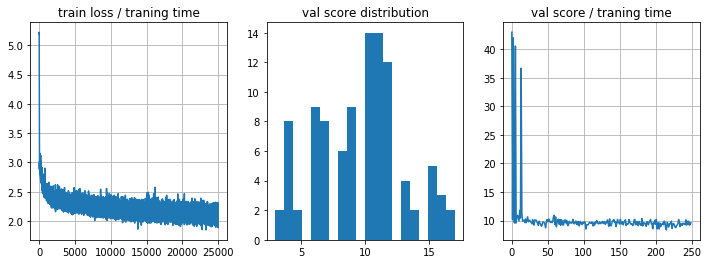

100%|██████████| 25000/25000 [08:01<00:00, 51.88it/s]

llh=2.114, mean score=9.515


In [22]:
loss_history=[]
editdist_history = []

for i in trange(25000):
    bx,by = sample_batch(train_words, word_to_translation, 32)
    
    feed_dict = {
        supervised_training.input_sequence:bx,
        supervised_training.reference_answers:by
    }
    
    loss, _ = s.run([supervised_training.loss,supervised_training.train_step], feed_dict)
    loss_history.append(loss)
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))
        
# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [23]:
for word in train_words[:10]:
    print("%s -> %s"%(word, translate([word])[0]))

כל אנשי סמיילי -> corge stand
קטגוריה:ערוץ 2 -> the mark sharn
עבודה מהבית -> barth stand
פראליה -> parton
קפלר 42 -> corth stand
קטגוריה:מתאסלמים -> maricha
בושמי -> banagar
לאונרדו -> langan
שאמה -> ravi
עכברה -> aliman


In [24]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
    
print("Supervised test score:", np.mean(test_scores))

100%|██████████| 407/407 [00:03<00:00, 105.21it/s]

Supervised test score: 9.34460498002


## Step 4: Make it actually work (up to 26 points)

In this section we want you to experiment to find a good model for the task.

**What would be good**:

1) try different recurrent units

2) implement attention - compulsory!

3) try bidirectional rnn/gru/lstm

4) try different functions for attention

5) any other ideas are welcome!

**Requirements**:

1) less than 1.2 llh

2) less than 6 points test score

3) don't change emb_size=32, hid_size=64 (if you're using bidirectional rnn, hid size for each must be 32 to get overall hid_size=64)

**What we expect to get**:

1) results with models in this notebook (top-n models)

2) a brief report describing your experiments and results: what have you tried, why, etc.

**What files you need to send**:

1) this notebook

2) file .py similar to ours basic_model.py with all your models and attentions


Firsly, let's try to replase casual RNN with LSTM

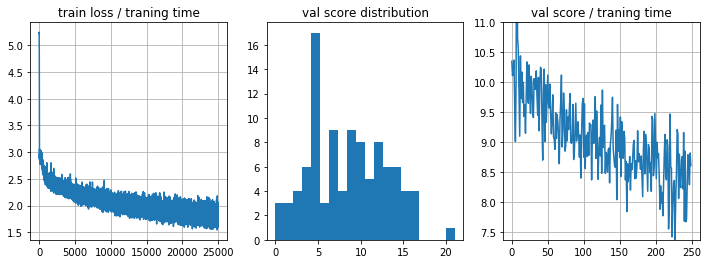

100%|██████████| 25000/25000 [14:23<00:00, 28.96it/s]

llh=1.855, mean score=8.340
כל אנשי סמיילי -> canina parica
קטגוריה:ערוץ 2 -> geore
עבודה מהבית -> solation sand
פראליה -> plari
קפלר 42 -> kf-10
קטגוריה:מתאסלמים -> matrichand
בושמי -> boshay
לאונרדו -> londer
שאמה -> shama
עכברה -> garand


Supervised test score: 8.32470027667


<function __main__.train.<locals>.translate>

In [25]:
from LSTM_model import LSTMTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = LSTMTranslationModel('model', inp_voc, out_voc,
                              emb_size=32, hid_size=64)

s.run(tf.global_variables_initializer())
train(model)

Now let's try GRU instead of LSTM. There are not so many data, so the GRU model can be better, because it has less parameters.

In [25]:
from GRU_model import GRUTranslationModel

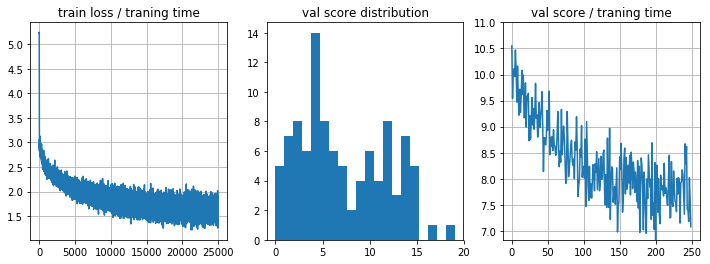

100%|██████████| 25000/25000 [13:27<00:00, 30.96it/s]

llh=1.585, mean score=7.760
כל אנשי סמיילי -> can silliam shari
קטגוריה:ערוץ 2 -> 200n senger
עבודה מהבית -> agian magim
פראליה -> parlay
קפלר 42 -> the 24 fal-1
קטגוריה:מתאסלמים -> mastamelles
בושמי -> boshmi
לאונרדו -> lanordo
שאמה -> shama
עכברה -> caration


Supervised test score: 7.78850292038


<function __main__.train.<locals>.translate>

In [27]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = GRUTranslationModel('model', inp_voc, out_voc,
                            emb_size=32, hid_size=64)

s.run(tf.global_variables_initializer())
train(model)

Acctually, we got the significantly better results with GRU. Now let's try bidirectional encoder.

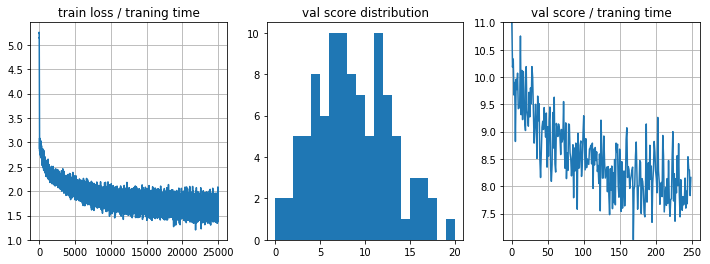

100%|██████████| 25000/25000 [13:13<00:00, 31.50it/s]

llh=1.633, mean score=8.022
כל אנשי סמיילי -> can silian masia
קטגוריה:ערוץ 2 -> 20 sentron
עבודה מהבית -> alital of the bood
פראליה -> parlia
קפלר 42 -> calte 40
קטגוריה:מתאסלמים -> mathelmands
בושמי -> boshemi
לאונרדו -> landro
שאמה -> sham
עכברה -> abraham


Supervised test score: 8.02705195204


<function __main__.train.<locals>.translate>

In [26]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = GRUTranslationModel('model', inp_voc, out_voc,
                            emb_size=32, hid_size=64, bidirectional=True)

s.run(tf.global_variables_initializer())
train(model)

The results become poorer. However, there is less point using bidirectional encoder without attention. So, now let's try to add attention to our model.

In [48]:
from GRU_with_attention_model import AttentionGRUTranslationModel

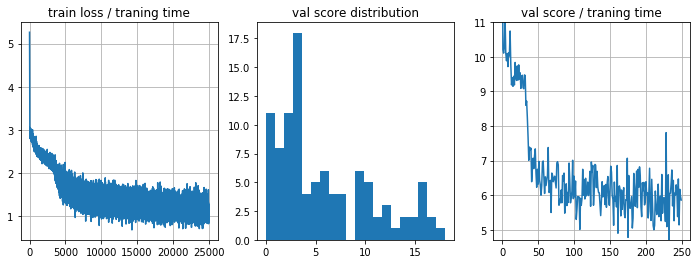

100%|██████████| 25000/25000 [44:33<00:00,  9.35it/s]

llh=1.111, mean score=5.948
כל אנשי סמיילי -> calmilian parish
קטגוריה:ערוץ 2 -> an shi
עבודה מהבית -> aboda mahavit
פראליה -> pralia
קפלר 42 -> capler 42
קטגוריה:מתאסלמים -> mathalemim
בושמי -> boshmay
לאונרדו -> launardo
שאמה -> shama
עכברה -> akabra


Supervised test score: 5.83023363049


<function __main__.train.<locals>.translate>

In [30]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('model', inp_voc, out_voc,
                                     emb_size=32, hid_size=64, attention_function='bilinear')

s.run(tf.global_variables_initializer())
train(model)

Did it! 

The boundary was passed, but let's try more stuff.

Let's look at the same model, but non-bidirectional.

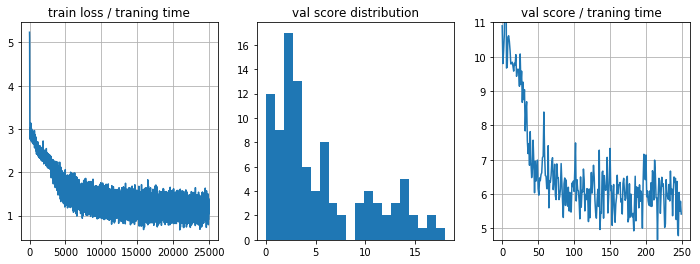

100%|██████████| 25000/25000 [45:07<00:00,  9.23it/s]

llh=1.191, mean score=5.700
כל אנשי סמיילי -> chal anshie smili
קטגוריה:ערוץ 2 -> fing cats
עבודה מהבית -> aboda maha
פראליה -> pralia
קפלר 42 -> kfaller 42
קטגוריה:מתאסלמים -> mataslamim
בושמי -> boshmi
לאונרדו -> launerdo
שאמה -> shama
עכברה -> achabra


Supervised test score: 5.81563172456


<function __main__.train.<locals>.translate>

In [23]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('model', inp_voc, out_voc,
                                     emb_size=32, hid_size=64,
                                     attention_function='bilinear',
                                     bidirectional=False)

s.run(tf.global_variables_initializer())
train(model)

Pretty much the same, may be a little bit better. Now let's try another attention function: multi-layer perceptron.

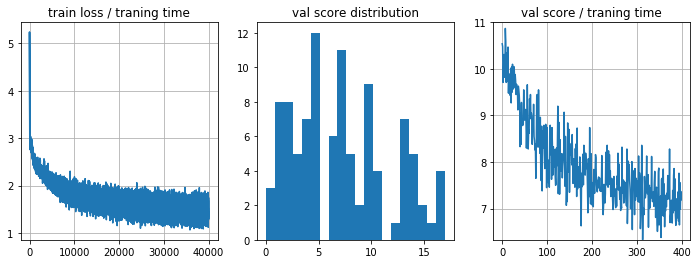

100%|██████████| 40000/40000 [1:00:22<00:00, 11.04it/s]

llh=1.481, mean score=7.155
כל אנשי סמיילי -> sali simi sini
קטגוריה:ערוץ 2 -> ara books
עבודה מהבית -> tome batting baba
פראליה -> parrialla
קפלר 42 -> kffer flef pelf
קטגוריה:מתאסלמים -> massess
בושמי -> boshmy
לאונרדו -> loondrono
שאמה -> shamah
עכברה -> abbara


Supervised test score: 7.2695972948


<function __main__.train.<locals>.translate>

In [51]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('model', inp_voc, out_voc,
                                     emb_size=32, hid_size=64,
                                     attention_function='perceptron',
                                     bidirectional=False)

s.run(tf.global_variables_initializer())
train(model, 40000)

Hmm, it doesn't look great. Probably, there are too many params. Let's try simpliest funcion - dot product.  
Actually, dot product is just a special case of a bilinear function with identity matrix. Therefore, unless we have enough data to train weights of a matrix in the bilinear function we'll be able to get at least the same results with bilinear as with dot product.

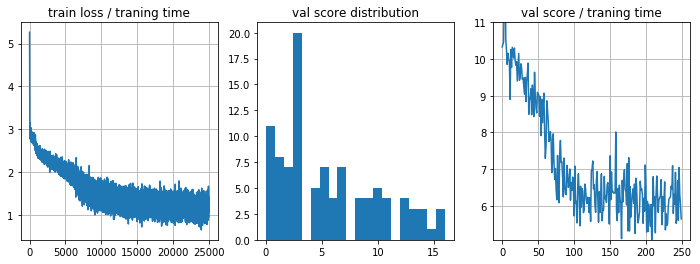

100%|██████████| 25000/25000 [44:14<00:00,  9.42it/s]

llh=1.205, mean score=6.145
כל אנשי סמיילי -> saili street cal
קטגוריה:ערוץ 2 -> north staces
עבודה מהבית -> avoda mahabit
פראליה -> pralia
קפלר 42 -> passler 42
קטגוריה:מתאסלמים -> mataslamim
בושמי -> boshmi
לאונרדו -> launerdo
שאמה -> shama
עכברה -> akhabra


Supervised test score: 5.97310175223


<function __main__.train.<locals>.translate>

In [49]:
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('model', inp_voc, out_voc,
                                     emb_size=32, hid_size=64,
                                     attention_function='dot product',
                                     bidirectional=False)

s.run(tf.global_variables_initializer())
train(model)

Looks like this model achieves worse results than the model with bilinear attention function. It means we have enough data to train weights of attention matrix :)